<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Ranidu-Gurusinghe/RandomForestClassifierModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing libraries

In [1]:
from google.colab import drive
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
!pip install scikit-learn==1.4.1.post1
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


#Downloading Datasets and loading models

In [2]:
# Mounting the Google Drive
drive.mount('/content/drive')

# Reading the data from the excel file and removing blank spaces in each cell
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/SL Apparel Industry Dataset.xlsx').apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Reading the JoinDates.xlsx file
join_dates_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/JoinedDates.xlsx')

Mounted at /content/drive


#Data Describing

looking at dataset

In [3]:
df.head()

,Date,Shift,Code,Department,Absenteeism Type,Status,Reason Mapping,Leave Type,Absent/Present,Reason
0,2021-12-01,Shift A,AA369,Team - MAT 4A - BD,Informed,Notified,NaN,1.0,MAT,Maternity
1,2021-12-01,Shift A,AA362,Team - MAT 4A - BD,Informed,Notified,NaN,1.0,MAT,Maternity
2,2021-12-01,Shift A,AA359,Team - MAT 4A - BD,Informed,Notified,NaN,1.0,MAT,Maternity
3,2021-12-01,Shift A,AA541,Team - MAT 4A - BD,Informed,Notified,NaN,1.0,MAT,Maternity
4,2021-12-01,Shift A,AA398,Team - MAT 3A - BD,Informed,Notified,NaN,1.0,MAT,Maternity


In [4]:
join_dates_df.head()

,Code,Joined Date
0,AA1,2013-06-05
1,AA2,2018-11-07
2,AA3,2012-11-21
3,AA4,2014-02-24
4,AA5,2016-09-21


In [5]:
print(df.isnull().sum())

Date                     0
Shift                    0
Code                     0
Department              10
Absenteeism Type       828
Status                 832
Reason Mapping      110537
Leave Type              79
Absent/Present          27
Reason                   0
dtype: int64


Unique Reasons: ['Maternity' 'No Message' 'Personal Reason' 'Health Related'
 'Child Related' 'Family Member - Health Related' 'Funeral'
 'Medical Leave' 'VOP' 'Hospitalized' 'Resignation' 'Pregnancy'
 'Family Member - Other' 'Before Maternity' 'Natural Disaster'
 'Child Care' 'Clinic' 'Flood' 'Cultural Celebration' 'Suspended'
 'After Maternity' 'Un Authorized No pay']


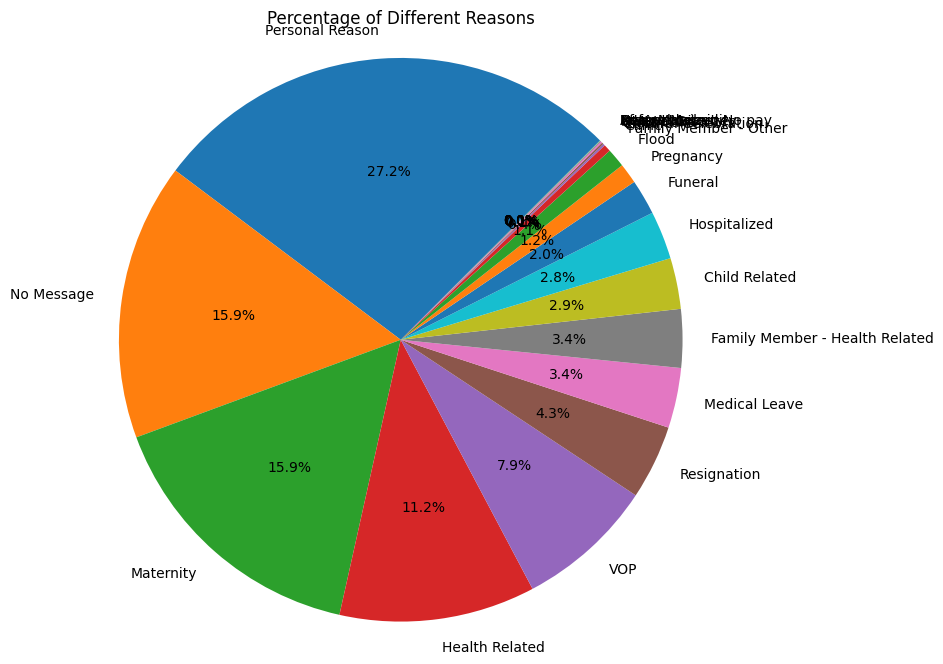

In [6]:
# Print unique reasons
unique_reasons = df['Reason'].unique()
print("Unique Reasons:", unique_reasons)

# Calculate percentage of different reasons
reason_counts = df['Reason'].value_counts()
reason_percentages = (reason_counts / reason_counts.sum()) * 100

# Plotting pie chart
plt.figure(figsize=(8, 8))
plt.pie(reason_percentages, labels=reason_counts.index, autopct='%1.1f%%', startangle=45)
plt.title('Percentage of Different Reasons')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


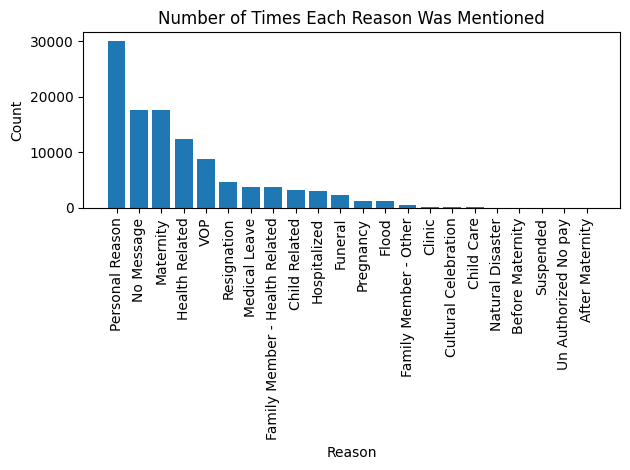

In [7]:
reason_counts = df['Reason'].value_counts()

# Create a bar chart
plt.bar(reason_counts.index, reason_counts.values)
plt.xlabel("Reason")
plt.ylabel("Count")
plt.title("Number of Times Each Reason Was Mentioned")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
# Group by month and reason
monthly_leave_reason_frequency = df.groupby([df['Date'].dt.month, 'Reason']).size().reset_index(name='NumOfLeaveDaysFrequency')

# Group by month and find the reason with the highest frequency
most_common_reason_per_month = monthly_leave_reason_frequency.groupby('Date').apply(lambda group: group.loc[group['NumOfLeaveDaysFrequency'].idxmax()])

# Print the result
print(most_common_reason_per_month)

      Date           Reason  NumOfLeaveDaysFrequency
Date                                                
1        1  Personal Reason                     3140
2        2  Personal Reason                     2526
3        3  Personal Reason                     3114
4        4  Personal Reason                     1993
5        5  Personal Reason                     3323
6        6  Personal Reason                     2995
7        7  Personal Reason                     1735
8        8  Personal Reason                     1869
9        9  Personal Reason                     1755
10      10  Personal Reason                     1834
11      11  Personal Reason                     1913
12      12  Personal Reason                     3919


In [9]:
# Group by month and find the reason with the second highest frequency
second_most_common_reason_per_month = monthly_leave_reason_frequency.groupby('Date').apply(lambda group: group.nlargest(2, 'NumOfLeaveDaysFrequency').iloc[-1])

# Print the result
print(second_most_common_reason_per_month)


      Date      Reason  NumOfLeaveDaysFrequency
Date                                           
1        1  No Message                     2670
2        2  No Message                     2458
3        3   Maternity                     1777
4        4  No Message                     1155
5        5  No Message                     1956
6        6   Maternity                     1644
7        7   Maternity                     1540
8        8   Maternity                     1190
9        9   Maternity                     1257
10      10   Maternity                     1573
11      11   Maternity                     1812
12      12  No Message                     3160


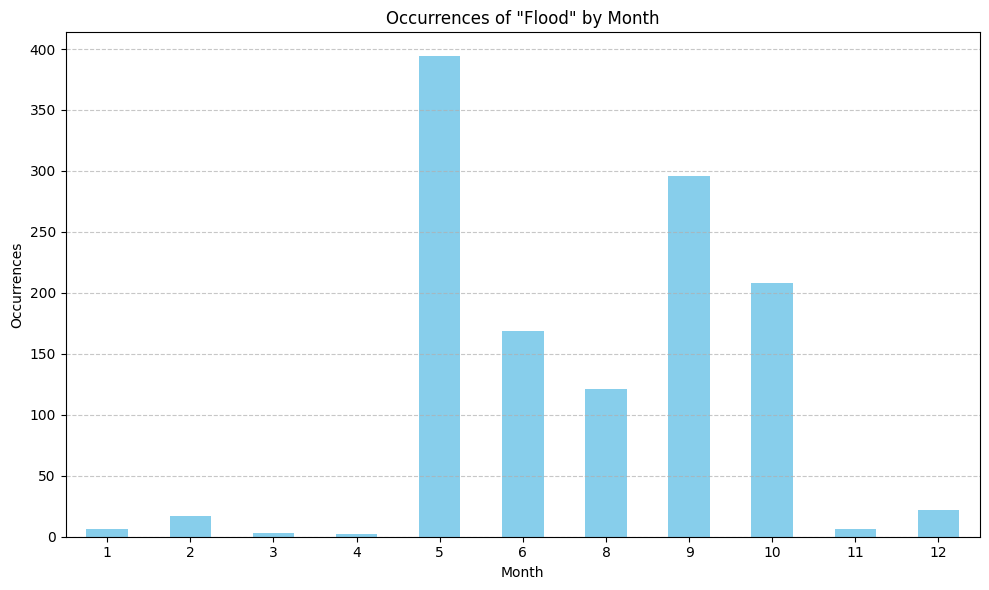

In [10]:
# Filter DataFrame for entries with reason "Natural Disaster" or "flood"
natural_disaster_flood_entries = df[ (df['Reason'] == 'Natural Disaster') | (df['Reason'] == 'Flood') ]

# Group by month and count the occurrences of "flood"
natural_disaster_flood_entries_by_month = natural_disaster_flood_entries.groupby(natural_disaster_flood_entries['Date'].dt.month).size()

# Plotting
plt.figure(figsize=(10, 6))
natural_disaster_flood_entries_by_month.plot(kind='bar', color='skyblue')
plt.title('Occurrences of "Flood" by Month')
plt.xlabel('Month')
plt.ylabel('Occurrences')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

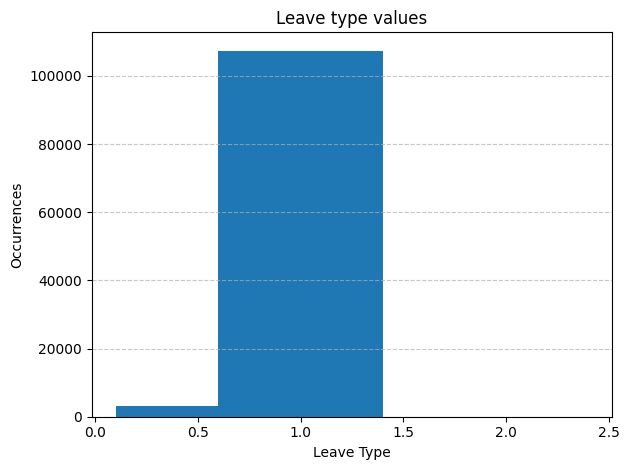

In [11]:
leave_type = df['Leave Type'].value_counts()

# Create a bar chart
plt.bar(leave_type.index, leave_type.values)
plt.title('Leave type values')
plt.xlabel('Leave Type')
plt.ylabel('Occurrences')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Preprocessing

Merging the 2 datasets on employee code

In [12]:
df = pd.merge(df, join_dates_df, on='Code', how='left')

In [13]:
df.shape

(110537, 11)

In [14]:
df = df.dropna(subset=['Joined Date'])

In [15]:
df.shape

(110455, 11)

## Data Cleaning

In [16]:
df['Joined Date'] = pd.to_datetime(df['Joined Date'])
# Making the 'Absenteeism Type' considered as String
df['Absenteeism Type'] = df['Absenteeism Type'].astype(str)

<ipython-input-16-35d8213ab629>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Joined Date'] = pd.to_datetime(df['Joined Date'])
<ipython-input-16-35d8213ab629>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Absenteeism Type'] = df['Absenteeism Type'].astype(str)


In [17]:
# Convert 'Code' column to numeric by removing 'AA' prefix
df['Encoded Code'] = pd.to_numeric(df['Code'].str.replace('AA', ''), errors='coerce')

In [18]:
# Calculating the number of years each employee has worked
df['DaysWorked'] = (df['Date'] - df['Joined Date']).dt.days

In [19]:
df.shape

(110455, 13)

In [20]:
# Add a column for the day of the week (1-7)
df['DayOfWeek'] = df['Date'].dt.dayofweek + 1

# Add a column for the month (1-12)
df['LeaveMonth'] = df['Date'].dt.month

# Create new columns for year and month
df['LeaveYear'] = df['Date'].dt.year

In [21]:
df.shape

(110455, 16)

In [22]:
df['Reason'] = df['Reason'].replace('Flood', 'Natural Disaster')

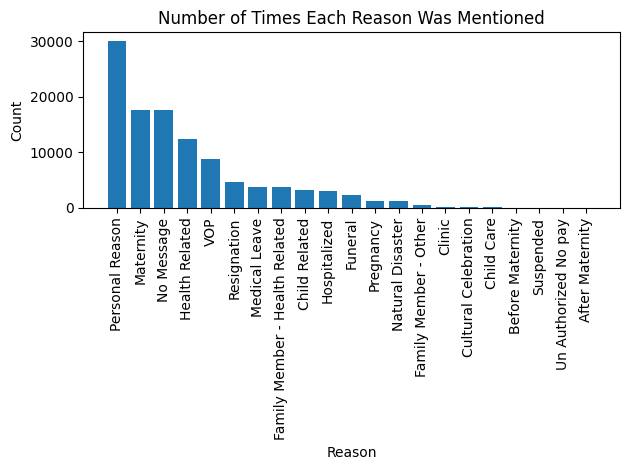

In [23]:
reason_counts = df['Reason'].value_counts()

# Create a bar chart
plt.bar(reason_counts.index, reason_counts.values)
plt.xlabel("Reason")
plt.ylabel("Count")
plt.title("Number of Times Each Reason Was Mentioned")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [24]:
reasons_to_remove = ['Resignation', 'VOP', 'Funeral']
df = df[~df['Reason'].isin(reasons_to_remove)]

In [25]:
df.shape

(94732, 16)

In [26]:
departments_to_remove = ['Bowlace & Bonding Team - BD', 'Team Not Available', 'Training Line - BD', 'VSM - 1A - Team - BD', 'VSM - 2A - Team - BD', 'VSM - 2B - Team - BD', 'VSM - 3A - Team - BD', 'VSM - 3B - Team - BD', 'VSM - 4B - Team - BD']
df = df[~df['Department'].isin(departments_to_remove)]
df = df.dropna(subset=['Department'])

In [27]:
print(df['Department'].unique())

['Team - MAT 4A - BD' 'Team - MAT 3A - BD' 'Team - MAT 2B - BD'
 'Team - MAT 2A - BD' 'Team - MAT 1B - BD' 'Team - MAT 1A - BD'
 'Sewing Team - 157B - II - BD' 'Sewing Team - 157B - I - BD'
 'Sewing Team - 157A - I - BD' 'Sewing Team - 156B - I - BD'
 'Sewing Team - 156A - I - BD' 'Sewing Team - 155B - II - BD'
 'Sewing Team - 155B - I - BD' 'Sewing Team - 155A - I - BD'
 'Sewing Team - 154B - I - BD' 'Sewing Team - 154A - I - BD'
 'Sewing Team - 153A - II - BD' 'Sewing Team - 153A - I - BD'
 'Sewing Team - 152B - II - BD' 'Sewing Team - 152B - I - BD'
 'Sewing Team - 152A - II - BD' 'Sewing Team - 151A - I - BD'
 'Sewing Team - 150B - II - BD' 'Sewing Team - 150B - I - BD'
 'Sewing Team - 150A - I - BD' 'Sewing Team - 149B - II - BD'
 'Sewing Team - 149B - I - BD' 'Sewing Team - 149A - I - BD'
 'Sewing Team - 148B - I - BD' 'Sewing Team - 148A - II - BD'
 'Sewing Team - 148A - I - BD' 'Sewing Team - 147A - I - BD'
 'Sewing Team - 146B - II - BD' 'Sewing Team - 146A - I - BD'
 'Sewing 

In [28]:
# Define a mapping of sub-departments to main departments
sub_dept_to_main_dept = {
    'Sewing Team': [sub_dept for sub_dept in df['Department'] if sub_dept.startswith('Sewing Team')],
    'Jumper Team': [sub_dept for sub_dept in df['Department'] if sub_dept.startswith('Jumper Team')],
    'MAT': [sub_dept for sub_dept in df['Department'] if sub_dept.startswith('Team - MAT')]
}

# Map each sub-department to its main department
main_dept_for_sub_dept = {}
for main_dept, sub_depts in sub_dept_to_main_dept.items():
    for sub_dept in sub_depts:
        main_dept_for_sub_dept[sub_dept] = main_dept

# Add a new column indicating the main department for each row
df['MainDepartment'] = df['Department'].map(main_dept_for_sub_dept)

In [29]:
print(df['MainDepartment'].isnull().sum())

5


In [30]:
df = df.dropna(subset=['MainDepartment'])
print(df['MainDepartment'].isnull().sum())


0


In [31]:
print(df['MainDepartment'].unique())

['MAT' 'Sewing Team' 'Jumper Team']


In [32]:
df.shape

(94535, 17)

In [33]:
# Replace blank values with 1
df['Leave Type'] = df['Leave Type'].fillna(1)

In [34]:
print(df.isnull().sum())

Date                    0
Shift                   0
Code                    0
Department              0
Absenteeism Type        0
Status                492
Reason Mapping      94535
Leave Type              0
Absent/Present         26
Reason                  0
Joined Date             0
Encoded Code            0
DaysWorked              0
DayOfWeek               0
LeaveMonth              0
LeaveYear               0
MainDepartment          0
dtype: int64


In [35]:
# Replace values in 'Shift' column using .loc[]
df.loc[df['Shift'] == 'A', 'Shift'] = 'Other Shifts'
df.loc[df['Shift'] == 'Shift', 'Shift'] = 'Other Shifts'
df.loc[df['Shift'] == 'Other Teams', 'Shift'] = 'Other Shifts'
df.loc[df['Shift'] == 'Shift e', 'Shift'] = 'Other Shifts'

In [36]:
df['Shift'].unique()

array(['Shift A', 'Shift B', 'Other Shifts'], dtype=object)

In [37]:
# Removing 'Department' and 'Reason Mapping' columns
df = df.drop(['Reason Mapping', 'Absent/Present'], axis=1)

In [38]:
df.shape

(94535, 15)

In [39]:
df['Absenteeism Type'] = df['Absenteeism Type'].replace('', 'Uninformed')
df['Status'] = df['Status'].fillna('Not Notified')

In [40]:
print(df.isnull().sum())

Date                0
Shift               0
Code                0
Department          0
Absenteeism Type    0
Status              0
Leave Type          0
Reason              0
Joined Date         0
Encoded Code        0
DaysWorked          0
DayOfWeek           0
LeaveMonth          0
LeaveYear           0
MainDepartment      0
dtype: int64


In [41]:
label_encoder = LabelEncoder()
df['Encoded Department'] = label_encoder.fit_transform(df['MainDepartment'])
df['Encoded Reason'] = label_encoder.fit_transform(df['Reason'])
df['Encoded Status'] = label_encoder.fit_transform(df['Status'])
df['Encoded Absenteeism Type'] = label_encoder.fit_transform(df['Absenteeism Type'])
df['Encoded Shift'] = label_encoder.fit_transform(df['Shift'])

In [42]:
df.shape

(94535, 20)

##Printing Data After Data Cleaning

In [43]:
df.head()

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Reason,Joined Date,Encoded Code,DaysWorked,DayOfWeek,LeaveMonth,LeaveYear,MainDepartment,Encoded Department,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift
0,2021-12-01,Shift A,AA369,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2015-09-11,369,2273,3,12,2021,MAT,1,10,1,0,1
1,2021-12-01,Shift A,AA362,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2018-11-14,362,1113,3,12,2021,MAT,1,10,1,0,1
2,2021-12-01,Shift A,AA359,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2019-10-09,359,784,3,12,2021,MAT,1,10,1,0,1
3,2021-12-01,Shift A,AA541,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2020-10-02,541,425,3,12,2021,MAT,1,10,1,0,1
4,2021-12-01,Shift A,AA398,Team - MAT 3A - BD,Informed,Notified,1.0,Maternity,2008-02-29,398,5024,3,12,2021,MAT,1,10,1,0,1


In [44]:
df.tail()

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Reason,Joined Date,Encoded Code,DaysWorked,DayOfWeek,LeaveMonth,LeaveYear,MainDepartment,Encoded Department,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift
110531,2023-12-22,Shift A,AA3992,Sewing Team - 142A - I - BD,Informed,Notified,1.0,Personal Reason,2022-03-15,3992,647,5,12,2023,Sewing Team,2,14,1,0,1
110532,2023-12-22,Shift A,AA3659,Sewing Team - 140A - I - BD,Informed,Notified,1.0,Medical Leave,2022-04-19,3659,612,5,12,2023,Sewing Team,2,11,1,0,1
110534,2023-12-22,Shift A,AA3845,Team - MAT 1A - BD,Informed,Notified,1.0,Maternity,2022-05-26,3845,575,5,12,2023,MAT,1,10,1,0,1
110535,2023-12-22,Shift A,AA3984,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2022-06-15,3984,555,5,12,2023,MAT,1,10,1,0,1
110536,2023-12-22,Shift A,AA4098,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2022-10-12,4098,436,5,12,2023,MAT,1,10,1,0,1


##Feature Engineering

In [45]:
# Create a dictionary to store leave dates for each employee
employee_leave_dates = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in df.iterrows():
    employee_code = row['Code']
    leave_date = row['Date']

    # Check if the employee code is already in the dictionary
    if employee_code in employee_leave_dates:
        # Append the leave date to the existing array
        employee_leave_dates[employee_code].append(leave_date)
    else:
        # Create a new array for the employee code
        employee_leave_dates[employee_code] = [leave_date]

In [46]:
# Create a dictionary to store leave dates and reasons for each employee
employee_leave_info = {}

# Iterate through the DataFrame to populate the dictionary
for index, row in df.iterrows():
    employee_code = row['Code']
    leave_date = row['Date']
    leave_reason = row['Reason']

    # Check if the employee code is already in the dictionary
    if employee_code in employee_leave_info:
        # Append the leave date and reason to the existing 2D array
        employee_leave_info[employee_code].append([leave_date, leave_reason])
    else:
        # Create a new 2D array for the employee code
        employee_leave_info[employee_code] = [[leave_date, leave_reason]]

In [47]:
# Create a new column to store the number of leaves taken by each employee in the next month
df['LeavesNextMonth'] = 0

# Iterate through the DataFrame to update the new column
for index, row in df.iterrows():
    employee_code = row['Code']
    leave_year = row['LeaveYear']
    leave_month = row['LeaveMonth']

    # Check if the employee code is in the dictionary
    if employee_code in employee_leave_dates:
        # Extract the year and month from the leave dates
        leave_years_months = [(date.year, date.month) for date in employee_leave_dates[employee_code]]

        # Check if the leave was taken in the next month and year
        if leave_month == 12:
            next_month = 1  # January of the next year
            next_year = leave_year + 1
        else:
            next_month = leave_month + 1
            next_year = leave_year

        if (next_year, next_month) in leave_years_months:
            # Count the number of leaves taken in the next month
            leaves_next_month = leave_years_months.count((next_year, next_month))
            df.at[index, 'LeavesNextMonth'] = leaves_next_month

In [48]:
# # Count consecutive leaves for each employee
# for index, row in df.iterrows():
#     employee_code = row['Code']
#     curr_date = row['Date']
#     consecutive_count = 0

#     if employee_code in employee_leave_info:
#         leave_info = employee_leave_info[employee_code]
#         if curr_date in [leave[0] for leave in leave_info]:
#             consecutive_count = 1
#             # Calculate the next day
#             while True:
#                 next_day = curr_date + timedelta(days=1)
#                 next_day_index = df[(df['Code'] == employee_code) & (df['Date'] == next_day)].index
#                 if not next_day_index.empty:
#                     # Remove the record for the next day
#                     df = df.drop(next_day_index)
#                     consecutive_count += 1
#                     curr_date = next_day
#                 else:
#                     break

#     # Update the 'NumOfLeaveDays' column in the DataFrame
#     df.at[index, 'NumOfLeaveDays'] = consecutive_count

In [49]:
df.shape

(94535, 21)

In [50]:
df.head()

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Reason,Joined Date,Encoded Code,...,DayOfWeek,LeaveMonth,LeaveYear,MainDepartment,Encoded Department,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeavesNextMonth
0,2021-12-01,Shift A,AA369,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2015-09-11,369,...,3,12,2021,MAT,1,10,1,0,1,0
1,2021-12-01,Shift A,AA362,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2018-11-14,362,...,3,12,2021,MAT,1,10,1,0,1,24
2,2021-12-01,Shift A,AA359,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2019-10-09,359,...,3,12,2021,MAT,1,10,1,0,1,16
3,2021-12-01,Shift A,AA541,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2020-10-02,541,...,3,12,2021,MAT,1,10,1,0,1,2
4,2021-12-01,Shift A,AA398,Team - MAT 3A - BD,Informed,Notified,1.0,Maternity,2008-02-29,398,...,3,12,2021,MAT,1,10,1,0,1,1


In [51]:
df.tail()

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Reason,Joined Date,Encoded Code,...,DayOfWeek,LeaveMonth,LeaveYear,MainDepartment,Encoded Department,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeavesNextMonth
110531,2023-12-22,Shift A,AA3992,Sewing Team - 142A - I - BD,Informed,Notified,1.0,Personal Reason,2022-03-15,3992,...,5,12,2023,Sewing Team,2,14,1,0,1,0
110532,2023-12-22,Shift A,AA3659,Sewing Team - 140A - I - BD,Informed,Notified,1.0,Medical Leave,2022-04-19,3659,...,5,12,2023,Sewing Team,2,11,1,0,1,0
110534,2023-12-22,Shift A,AA3845,Team - MAT 1A - BD,Informed,Notified,1.0,Maternity,2022-05-26,3845,...,5,12,2023,MAT,1,10,1,0,1,0
110535,2023-12-22,Shift A,AA3984,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2022-06-15,3984,...,5,12,2023,MAT,1,10,1,0,1,0
110536,2023-12-22,Shift A,AA4098,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2022-10-12,4098,...,5,12,2023,MAT,1,10,1,0,1,0


In [52]:
print(df.isnull().sum())

Date                        0
Shift                       0
Code                        0
Department                  0
Absenteeism Type            0
Status                      0
Leave Type                  0
Reason                      0
Joined Date                 0
Encoded Code                0
DaysWorked                  0
DayOfWeek                   0
LeaveMonth                  0
LeaveYear                   0
MainDepartment              0
Encoded Department          0
Encoded Reason              0
Encoded Status              0
Encoded Absenteeism Type    0
Encoded Shift               0
LeavesNextMonth             0
dtype: int64


In [53]:
df = df.dropna()

In [54]:
df.tail()

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Reason,Joined Date,Encoded Code,...,DayOfWeek,LeaveMonth,LeaveYear,MainDepartment,Encoded Department,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeavesNextMonth
110531,2023-12-22,Shift A,AA3992,Sewing Team - 142A - I - BD,Informed,Notified,1.0,Personal Reason,2022-03-15,3992,...,5,12,2023,Sewing Team,2,14,1,0,1,0
110532,2023-12-22,Shift A,AA3659,Sewing Team - 140A - I - BD,Informed,Notified,1.0,Medical Leave,2022-04-19,3659,...,5,12,2023,Sewing Team,2,11,1,0,1,0
110534,2023-12-22,Shift A,AA3845,Team - MAT 1A - BD,Informed,Notified,1.0,Maternity,2022-05-26,3845,...,5,12,2023,MAT,1,10,1,0,1,0
110535,2023-12-22,Shift A,AA3984,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2022-06-15,3984,...,5,12,2023,MAT,1,10,1,0,1,0
110536,2023-12-22,Shift A,AA4098,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2022-10-12,4098,...,5,12,2023,MAT,1,10,1,0,1,0


In [55]:
# def onehot_encode(df, column, prefix):
#     df = df.copy()

#     dummies = pd.get_dummies(df[column], prefix=prefix)
#     df = pd.concat([df, dummies], axis=1)
#     df = df.drop(column, axis=1)

#     return df

# df = onehot_encode(
#     df,
#     column='Encoded Reason',
#     prefix='Reason'
# )

In [56]:
# Create a new column to indicate if an employee took leave the next month
df['TookLeaveNextMonth'] = 0

# Iterate through the DataFrame to update the new column
for index, row in df.iterrows():
    employee_code = row['Code']
    leave_year = row['LeaveYear']
    leave_month = row['LeaveMonth']

    # Check if the employee code is in the dictionary
    if employee_code in employee_leave_dates:
        # Extract the year and month from the leave dates
        leave_years_months = [(date.year, date.month) for date in employee_leave_dates[employee_code]]

        # Check if the leave was taken in the next month and year
        if leave_month == 12:
            next_month = 1  # January of the next year
            next_year = leave_year + 1
        else:
            next_month = leave_month + 1
            next_year = leave_year

        if (next_year, next_month) in leave_years_months:
            df.at[index, 'TookLeaveNextMonth'] = 1

In [57]:
df.head()

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Reason,Joined Date,Encoded Code,...,LeaveMonth,LeaveYear,MainDepartment,Encoded Department,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeavesNextMonth,TookLeaveNextMonth
0,2021-12-01,Shift A,AA369,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2015-09-11,369,...,12,2021,MAT,1,10,1,0,1,0,0
1,2021-12-01,Shift A,AA362,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2018-11-14,362,...,12,2021,MAT,1,10,1,0,1,24,1
2,2021-12-01,Shift A,AA359,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2019-10-09,359,...,12,2021,MAT,1,10,1,0,1,16,1
3,2021-12-01,Shift A,AA541,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2020-10-02,541,...,12,2021,MAT,1,10,1,0,1,2,1
4,2021-12-01,Shift A,AA398,Team - MAT 3A - BD,Informed,Notified,1.0,Maternity,2008-02-29,398,...,12,2021,MAT,1,10,1,0,1,1,1


In [58]:
df.shape

(94535, 22)

In [59]:
# Create a new column to represent the target variable categories
df['TargetCategory'] = pd.cut(df['LeavesNextMonth'], bins=[-1, 2,float('inf')],
                              labels=['A', 'B'], right=False)

In [60]:
df.head()

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Reason,Joined Date,Encoded Code,...,LeaveYear,MainDepartment,Encoded Department,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeavesNextMonth,TookLeaveNextMonth,TargetCategory
0,2021-12-01,Shift A,AA369,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2015-09-11,369,...,2021,MAT,1,10,1,0,1,0,0,A
1,2021-12-01,Shift A,AA362,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2018-11-14,362,...,2021,MAT,1,10,1,0,1,24,1,B
2,2021-12-01,Shift A,AA359,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2019-10-09,359,...,2021,MAT,1,10,1,0,1,16,1,B
3,2021-12-01,Shift A,AA541,Team - MAT 4A - BD,Informed,Notified,1.0,Maternity,2020-10-02,541,...,2021,MAT,1,10,1,0,1,2,1,B
4,2021-12-01,Shift A,AA398,Team - MAT 3A - BD,Informed,Notified,1.0,Maternity,2008-02-29,398,...,2021,MAT,1,10,1,0,1,1,1,A


#Train-Test Split

removing december data because target feature cannot be setup

In [61]:
df = df[df['Date'] < '2023-12-01']

In [62]:
df.shape

(92498, 23)

extracting data from last 3 months(sept, oct, nov)

In [63]:
nov_df = df[df['Date'] >= '2023-11-01']
df = df[df['Date'] < '2023-11-01']

In [64]:
nov_df.shape

(2868, 23)

In [65]:
oct_df = df[df['Date'] >= '2023-10-01']
df = df[df['Date'] < '2023-10-01']

In [66]:
oct_df.shape

(2223, 23)

In [67]:
sept_df = df[df['Date'] >= '2023-09-01']
df = df[df['Date'] < '2023-09-01']

In [68]:
sept_df.shape

(2317, 23)

final training dataset size

In [69]:
df.shape

(85090, 23)

In [70]:
df.columns

Index(['Date', 'Shift', 'Code', 'Department', 'Absenteeism Type', 'Status',
       'Leave Type', 'Reason', 'Joined Date', 'Encoded Code', 'DaysWorked',
       'DayOfWeek', 'LeaveMonth', 'LeaveYear', 'MainDepartment',
       'Encoded Department', 'Encoded Reason', 'Encoded Status',
       'Encoded Absenteeism Type', 'Encoded Shift', 'LeavesNextMonth',
       'TookLeaveNextMonth', 'TargetCategory'],
      dtype='object')

In [76]:
features  = ['Encoded Code', 'Encoded Department', 'DaysWorked', 'DayOfWeek',
             'LeaveMonth', 'LeaveYear', 'Encoded Reason','Encoded Status',
             'Encoded Absenteeism Type', 'Encoded Shift']

In [77]:
X_train = df[features]
Y_train = df['TargetCategory']

In [78]:
X_train.head()

,Encoded Code,Encoded Department,DaysWorked,DayOfWeek,LeaveMonth,LeaveYear,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift
0,369,1,2273,3,12,2021,10,1,0,1
1,362,1,1113,3,12,2021,10,1,0,1
2,359,1,784,3,12,2021,10,1,0,1
3,541,1,425,3,12,2021,10,1,0,1
4,398,1,5024,3,12,2021,10,1,0,1


In [79]:
X_train.shape

(85090, 10)

In [80]:
Y_train.shape

(85090,)

In [134]:
X_test = nov_df[features]
Y_test = nov_df['TargetCategory']

In [135]:
X_test.head()

,Encoded Code,Encoded Department,DaysWorked,DayOfWeek,LeaveMonth,LeaveYear,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift
105229,1878,2,6757,3,11,2023,11,1,0,2
105230,2472,2,5892,3,11,2023,14,1,0,2
105231,86,2,972,3,11,2023,13,0,1,2
105232,2709,2,5623,3,11,2023,13,0,1,2
105233,559,0,5601,3,11,2023,8,1,1,2


In [136]:
X_test.shape

(2868, 10)

In [137]:
Y_test.shape

(2868,)

#Model Training

In [85]:
from sklearn. ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=500, max_depth=40,random_state=123)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=40, n_estimators=500, random_state=123)

#Model Testing

In [138]:
from sklearn.metrics import accuracy_score


predictions_rf = rf_model.predict(X_test)
results_df = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions_rf})
accuracy = accuracy_score(Y_test, predictions_rf)


print("Actual values and predictions:")
print(results_df)
print("\n\nAccuracy of Predicted Classes:", accuracy)

Actual values and predictions:
       Actual Predicted
105229      A         A
105230      A         A
105231      A         A
105232      A         A
105233      A         A
...       ...       ...
108350      B         A
108351      B         B
108352      B         B
108353      B         B
108354      B         A

[2868 rows x 2 columns]


Accuracy of Predicted Classes: 0.6576011157601116


In [139]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(Y_test, predictions_rf)

# Print the classification report
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           A       0.59      0.84      0.69      1330
           B       0.78      0.50      0.61      1538

    accuracy                           0.66      2868
   macro avg       0.69      0.67      0.65      2868
weighted avg       0.69      0.66      0.65      2868



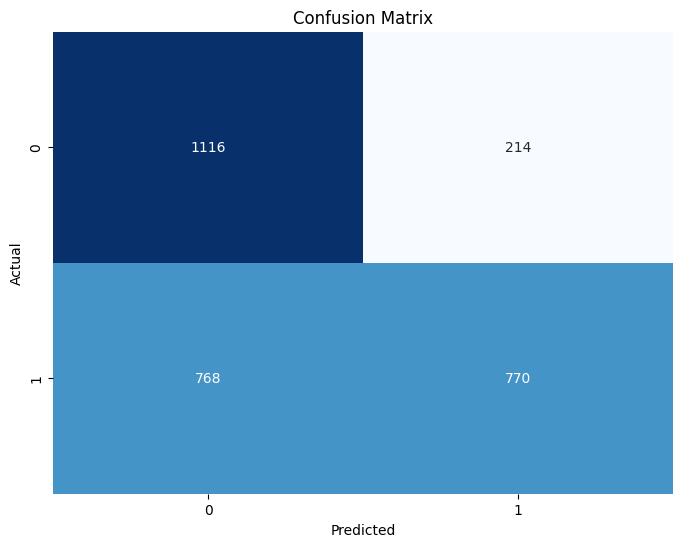

In [140]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(Y_test, predictions_rf)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [141]:
df.shape

(85090, 23)

##Adding monthly department leaves to the dataset

In [90]:
total_absence_by_main_dept = df.groupby(['Encoded Department', 'LeaveYear','LeaveMonth']).size().reset_index(name='totalAbsence')
print(total_absence_by_main_dept)

    Encoded Department  LeaveYear  LeaveMonth  totalAbsence
0                    0       2021          12           170
1                    0       2022           1           153
2                    0       2022           2           288
3                    0       2022           3           392
4                    0       2022           4           299
..                 ...        ...         ...           ...
58                   2       2023           4           498
59                   2       2023           5          1965
60                   2       2023           6          1587
61                   2       2023           7          1612
62                   2       2023           8          1413

[63 rows x 4 columns]


In [91]:
jumper_team_monthly_leaves = {}
mat_team_monthly_leaves = {}
sewing_team_monthly_leaves = {}

for index, row in total_absence_by_main_dept.iterrows():
  year = row['LeaveYear']
  month = row['LeaveMonth']
  if row['Encoded Department'] == 0:
      jumper_team_monthly_leaves[(year, month)] = row['totalAbsence']
  elif row['Encoded Department'] == 1:
      mat_team_monthly_leaves[(year, month)] = row['totalAbsence']
  elif row['Encoded Department'] == 2:
      sewing_team_monthly_leaves[(year, month)] = row['totalAbsence']



In [92]:
print(jumper_team_monthly_leaves[2021, 12])
print(mat_team_monthly_leaves[2021, 12])
print(sewing_team_monthly_leaves[2023, 8])

170
760
1413


In [142]:
X_train_updated = X_train.copy()

In [143]:
X_train_updated.shape

(85090, 10)

In [144]:
X_train_updated['MonthlyDeptTotal'] = 0
for index, row in X_train_updated.iterrows():
  year = row['LeaveYear']
  month = row['LeaveMonth']
  if row['Encoded Department'] == 0:
    X_train_updated.at[index, 'MonthlyDeptTotal'] = jumper_team_monthly_leaves[(year, month)]
  elif row['Encoded Department'] == 1:
    X_train_updated.at[index, 'MonthlyDeptTotal'] = mat_team_monthly_leaves[(year, month)]
  elif row['Encoded Department'] == 2:
    X_train_updated.at[index, 'MonthlyDeptTotal'] = sewing_team_monthly_leaves[(year, month)]

In [145]:
X_train_updated.head()

,Encoded Code,Encoded Department,DaysWorked,DayOfWeek,LeaveMonth,LeaveYear,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,MonthlyDeptTotal
0,369,1,2273,3,12,2021,10,1,0,1,760
1,362,1,1113,3,12,2021,10,1,0,1,760
2,359,1,784,3,12,2021,10,1,0,1,760
3,541,1,425,3,12,2021,10,1,0,1,760
4,398,1,5024,3,12,2021,10,1,0,1,760


In [146]:
X_train_updated.tail()

,Encoded Code,Encoded Department,DaysWorked,DayOfWeek,LeaveMonth,LeaveYear,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,MonthlyDeptTotal
101270,3577,2,674,4,8,2023,11,0,2,1,1413
101271,3595,2,649,4,8,2023,14,0,2,2,1413
101272,3426,2,898,4,8,2023,11,0,2,1,1413
101273,4126,2,259,4,8,2023,8,0,2,1,1413
101274,2155,2,3573,4,8,2023,14,0,2,1,1413


#Loading SARIMAX Models

In [125]:
import pickle

In [98]:
def ts_load_model(model_path):
    with open(model_path, 'rb') as file:
        return pickle.load(file)

In [99]:
sewing_model = ts_load_model(
   '/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Models/Sewing_sarimax.pkl')


mat_model = ts_load_model(
    '/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Models/Mat_sarimax.pkl')


jumper_model = ts_load_model(
    '/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Models/Jumper_sarimax.pkl')

Getting forecast

In [100]:
sewing_forecast = sewing_model.forecast(steps = 3)

mat_forecast = mat_model.forecast(steps=3)

jumper_forecast = jumper_model.forecast(steps=3)

In [101]:
print(sewing_forecast)
print(mat_forecast)
print(jumper_forecast)

22    1005.357151
23    1111.169847
24     801.161732
Name: predicted_mean, dtype: float64
22    133.656637
23    168.877692
24    104.409006
Name: predicted_mean, dtype: float64
22    65.075924
23    78.466549
24    61.275794
Name: predicted_mean, dtype: float64


In [102]:
def add_to_dataset(df, sewing_forecast, mat_forecast, jumper_forecast):
    sewing_forecast = int(sewing_forecast)
    mat_forecast = int(mat_forecast)
    jumper_forecast = int(jumper_forecast)
    for index, row in df.iterrows():
        sub_dept = row['Encoded Department']
        if sub_dept == 2:
            df.at[index, 'MonthlyDeptTotal'] = sewing_forecast
        elif sub_dept == 1:
            df.at[index, 'MonthlyDeptTotal'] = mat_forecast
        elif sub_dept == 0:
            df.at[index, 'MonthlyDeptTotal'] = jumper_forecast
    return df

In [147]:
starting_index = X_test.index[0]

In [148]:
if X_test['LeaveYear'][starting_index] == 2023 and X_test['LeaveMonth'][starting_index] == 9:
    X_test_updated = add_to_dataset(X_test, sewing_forecast[22], mat_forecast[22], jumper_forecast[22])
elif X_test['LeaveYear'][starting_index] == 2023 and X_test['LeaveMonth'][starting_index] == 10:
    X_test_updated = add_to_dataset(X_test, sewing_forecast[23], mat_forecast[23], jumper_forecast[23])
elif X_test['LeaveYear'][starting_index] == 2023 and X_test['LeaveMonth'][starting_index] == 11:
    X_test_updated = add_to_dataset(X_test, sewing_forecast[24], mat_forecast[24], jumper_forecast[24])


<ipython-input-102-90339815c401>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, 'MonthlyDeptTotal'] = sewing_forecast


In [149]:
X_test_updated.head()

,Encoded Code,Encoded Department,DaysWorked,DayOfWeek,LeaveMonth,LeaveYear,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,MonthlyDeptTotal
105229,1878,2,6757,3,11,2023,11,1,0,2,801.0
105230,2472,2,5892,3,11,2023,14,1,0,2,801.0
105231,86,2,972,3,11,2023,13,0,1,2,801.0
105232,2709,2,5623,3,11,2023,13,0,1,2,801.0
105233,559,0,5601,3,11,2023,8,1,1,2,61.0


In [151]:
X_test_updated.tail()

,Encoded Code,Encoded Department,DaysWorked,DayOfWeek,LeaveMonth,LeaveYear,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,MonthlyDeptTotal
108350,4261,2,658,4,11,2023,13,0,1,1,801.0
108351,3845,1,553,4,11,2023,10,1,0,1,104.0
108352,3984,1,533,4,11,2023,10,1,0,1,104.0
108353,4098,1,414,4,11,2023,10,1,0,1,104.0
108354,4106,2,316,4,11,2023,11,1,0,1,801.0


In [152]:
X_test_updated.shape

(2868, 11)

#Model with time series data

In [108]:
rf_model_ts = RandomForestClassifier(n_estimators=500, max_depth=40,random_state=123)
rf_model_ts.fit(X_train_updated, Y_train)

RandomForestClassifier(max_depth=40, n_estimators=500, random_state=123)

In [153]:
from sklearn.metrics import accuracy_score


predictions_rf_ts = rf_model_ts.predict(X_test_updated)
results_df = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions_rf_ts})
accuracy = accuracy_score(Y_test, predictions_rf_ts)


print("Actual values and predictions:")
print(results_df)
print("\n\nAccuracy of Predicted Classes:", accuracy)

Actual values and predictions:
       Actual Predicted
105229      A         A
105230      A         A
105231      A         A
105232      A         A
105233      A         A
...       ...       ...
108350      B         A
108351      B         B
108352      B         B
108353      B         B
108354      B         B

[2868 rows x 2 columns]


Accuracy of Predicted Classes: 0.698744769874477


In [154]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(Y_test, predictions_rf_ts)

# Print the classification report
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           A       0.66      0.74      0.69      1330
           B       0.74      0.67      0.70      1538

    accuracy                           0.70      2868
   macro avg       0.70      0.70      0.70      2868
weighted avg       0.70      0.70      0.70      2868



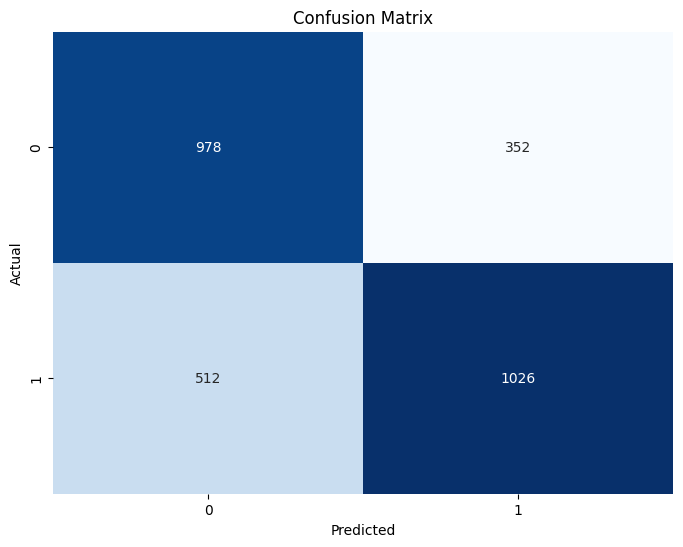

In [155]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(Y_test, predictions_rf_ts)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Data Visualization of predictions

In [162]:
# Get the predicted probabilities for each class
predicted_probabilities = rf_model_ts.predict_proba(X_test_updated)

# Get the index of class B
class_b_index = list(rf_model_ts.classes_).index('B')

# Extract the probabilities for class B
class_b_probabilities = predicted_probabilities[:, class_b_index]

# Assuming the confidence level is the probability of class B
confidence_level_b = class_b_probabilities

# Iterate over each prediction in class B
for i, (actual, predicted, probability) in enumerate(zip(Y_test, predictions_rf, confidence_level_b)):
    if predicted == 'B':
        print(f"Actual: {actual}, Predicted: {predicted}, Probability: {probability}")

Actual: B, Predicted: B, Probability: 0.628
Actual: B, Predicted: B, Probability: 0.696
Actual: B, Predicted: B, Probability: 0.906
Actual: A, Predicted: B, Probability: 0.54
Actual: A, Predicted: B, Probability: 0.856
Actual: A, Predicted: B, Probability: 0.774
Actual: B, Predicted: B, Probability: 0.674
Actual: B, Predicted: B, Probability: 0.746
Actual: B, Predicted: B, Probability: 0.72
Actual: B, Predicted: B, Probability: 0.862
Actual: B, Predicted: B, Probability: 0.682
Actual: B, Predicted: B, Probability: 0.916
Actual: B, Predicted: B, Probability: 0.914
Actual: A, Predicted: B, Probability: 0.914
Actual: B, Predicted: B, Probability: 0.936
Actual: B, Predicted: B, Probability: 0.674
Actual: B, Predicted: B, Probability: 0.796
Actual: B, Predicted: B, Probability: 0.942
Actual: B, Predicted: B, Probability: 0.932
Actual: B, Predicted: B, Probability: 0.636
Actual: B, Predicted: B, Probability: 0.628
Actual: B, Predicted: B, Probability: 0.752
Actual: A, Predicted: B, Probabili

In [168]:
# Filter predictions with probability > 0.9
high_confidence_predictions = [(actual, predicted, probability) for actual, predicted, probability in zip(Y_test, predictions_rf, confidence_level_b) if probability > 0.75]

# Display filtered predictions
for actual, predicted, probability in high_confidence_predictions:
    print(f"Actual: {actual}, Predicted: {predicted}, Probability: {probability}")

Actual: B, Predicted: B, Probability: 0.906
Actual: A, Predicted: B, Probability: 0.856
Actual: A, Predicted: B, Probability: 0.774
Actual: B, Predicted: B, Probability: 0.862
Actual: B, Predicted: B, Probability: 0.916
Actual: B, Predicted: B, Probability: 0.914
Actual: A, Predicted: B, Probability: 0.914
Actual: B, Predicted: B, Probability: 0.936
Actual: B, Predicted: B, Probability: 0.796
Actual: B, Predicted: B, Probability: 0.942
Actual: B, Predicted: B, Probability: 0.932
Actual: B, Predicted: B, Probability: 0.752
Actual: A, Predicted: B, Probability: 0.802
Actual: B, Predicted: B, Probability: 0.792
Actual: B, Predicted: B, Probability: 0.908
Actual: A, Predicted: B, Probability: 0.854
Actual: A, Predicted: B, Probability: 0.782
Actual: B, Predicted: B, Probability: 0.754
Actual: B, Predicted: B, Probability: 0.78
Actual: B, Predicted: B, Probability: 0.864
Actual: B, Predicted: B, Probability: 0.914
Actual: B, Predicted: B, Probability: 0.916
Actual: A, Predicted: B, Probabil

In [179]:
# Filter predictions with probability > 0.9 and predicted as category B
high_confidence_category_b = [(X_test.iloc[i]['Encoded Code'], X_test.iloc[i]['Encoded Department']) for i, (_, predicted, probability) in enumerate(zip(Y_test, predictions_rf, confidence_level_b)) if predicted == 'B' and probability > 0.8]

# Display encoded codes and corresponding departments of employees predicted to be in category B with >0.9 probability
print("Encoded codes and corresponding departments of employees predicted to be in category B with > 0.9 probability:")
for encoded_code, encoded_department in high_confidence_category_b:
    print(f"Encoded Code: AA{encoded_code}, Encoded Department: {encoded_department}")

print(len(high_confidence_category_b))


Encoded codes and corresponding departments of employees predicted to be in category B with > 0.9 probability:
Encoded Code: AA4096.0, Encoded Department: 1.0
Encoded Code: AA243.0, Encoded Department: 1.0
Encoded Code: AA320.0, Encoded Department: 1.0
Encoded Code: AA4042.0, Encoded Department: 1.0
Encoded Code: AA4036.0, Encoded Department: 1.0
Encoded Code: AA4032.0, Encoded Department: 1.0
Encoded Code: AA2648.0, Encoded Department: 1.0
Encoded Code: AA2365.0, Encoded Department: 1.0
Encoded Code: AA3895.0, Encoded Department: 1.0
Encoded Code: AA1965.0, Encoded Department: 1.0
Encoded Code: AA4096.0, Encoded Department: 1.0
Encoded Code: AA243.0, Encoded Department: 1.0
Encoded Code: AA320.0, Encoded Department: 1.0
Encoded Code: AA4042.0, Encoded Department: 1.0
Encoded Code: AA4036.0, Encoded Department: 1.0
Encoded Code: AA4032.0, Encoded Department: 1.0
Encoded Code: AA2648.0, Encoded Department: 1.0
Encoded Code: AA2365.0, Encoded Department: 1.0
Encoded Code: AA3895.0, Encod

In [178]:
high_confidence_category_b = [(actual, predicted, X_test.iloc[i]['Encoded Code'], X_test.iloc[i]['Encoded Department']) for i, (actual, predicted, probability) in enumerate(zip(Y_test, predictions_rf, confidence_level_b)) if predicted == 'B' and probability > 0.8 and X_test.iloc[i]['Encoded Department'] == 2]

# Display encoded codes, corresponding departments, actual class, and predicted class of employees predicted to be in category B with >0.9 probability
print("Encoded codes, corresponding departments, actual class, and predicted class of employees predicted to be in category B with > 0.9 probability:")
for actual_class, predicted_class, encoded_code, encoded_department in high_confidence_category_b:
    print(f"Actual Class: {actual_class}, Predicted Class: {predicted_class}, Encoded Code: AA{encoded_code}, Encoded Department: {encoded_department}")

print(len(high_confidence_category_b))



Encoded codes, corresponding departments, actual class, and predicted class of employees predicted to be in category B with > 0.9 probability:
Actual Class: B, Predicted Class: B, Encoded Code: AA2414.0, Encoded Department: 2.0
Actual Class: B, Predicted Class: B, Encoded Code: AA2414.0, Encoded Department: 2.0
Actual Class: B, Predicted Class: B, Encoded Code: AA2414.0, Encoded Department: 2.0
Actual Class: B, Predicted Class: B, Encoded Code: AA2414.0, Encoded Department: 2.0
Actual Class: A, Predicted Class: B, Encoded Code: AA1318.0, Encoded Department: 2.0
Actual Class: A, Predicted Class: B, Encoded Code: AA2781.0, Encoded Department: 2.0
6


In [180]:
high_confidence_category_b = [(actual, predicted, X_test.iloc[i]['Encoded Code'], X_test.iloc[i]['Encoded Department']) for i, (actual, predicted, probability) in enumerate(zip(Y_test, predictions_rf, confidence_level_b)) if predicted == 'B' and probability > 0.8 and X_test.iloc[i]['Encoded Department'] == 1]

# Display encoded codes, corresponding departments, actual class, and predicted class of employees predicted to be in category B with >0.9 probability
print("Encoded codes, corresponding departments, actual class, and predicted class of employees predicted to be in category B with > 0.9 probability:")
for actual_class, predicted_class, encoded_code, encoded_department in high_confidence_category_b:
    print(f"Actual Class: {actual_class}, Predicted Class: {predicted_class}, Encoded Code: AA{encoded_code}, Encoded Department: {encoded_department}")

print(len(high_confidence_category_b))

Encoded codes, corresponding departments, actual class, and predicted class of employees predicted to be in category B with > 0.9 probability:
Actual Class: B, Predicted Class: B, Encoded Code: AA4096.0, Encoded Department: 1.0
Actual Class: A, Predicted Class: B, Encoded Code: AA243.0, Encoded Department: 1.0
Actual Class: B, Predicted Class: B, Encoded Code: AA320.0, Encoded Department: 1.0
Actual Class: B, Predicted Class: B, Encoded Code: AA4042.0, Encoded Department: 1.0
Actual Class: B, Predicted Class: B, Encoded Code: AA4036.0, Encoded Department: 1.0
Actual Class: A, Predicted Class: B, Encoded Code: AA4032.0, Encoded Department: 1.0
Actual Class: B, Predicted Class: B, Encoded Code: AA2648.0, Encoded Department: 1.0
Actual Class: B, Predicted Class: B, Encoded Code: AA2365.0, Encoded Department: 1.0
Actual Class: B, Predicted Class: B, Encoded Code: AA3895.0, Encoded Department: 1.0
Actual Class: A, Predicted Class: B, Encoded Code: AA1965.0, Encoded Department: 1.0
Actual Cl